# NPK - Analysis and Prediction

### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

import plotly.graph_objects as go

import statsmodels.api as sm

import warnings

warnings.filterwarnings("ignore")

### Importing Data

In [2]:
__ROOT_PATH__ = Path().resolve().parent
file = "Crop_recommendation.csv"

data_path = os.path.join(__ROOT_PATH__, "data", file)

In [3]:
df_main = pd.read_csv(data_path, sep=",")
df_main.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [4]:
df_main.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [5]:
df_main.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [6]:
df_main.dtypes

N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

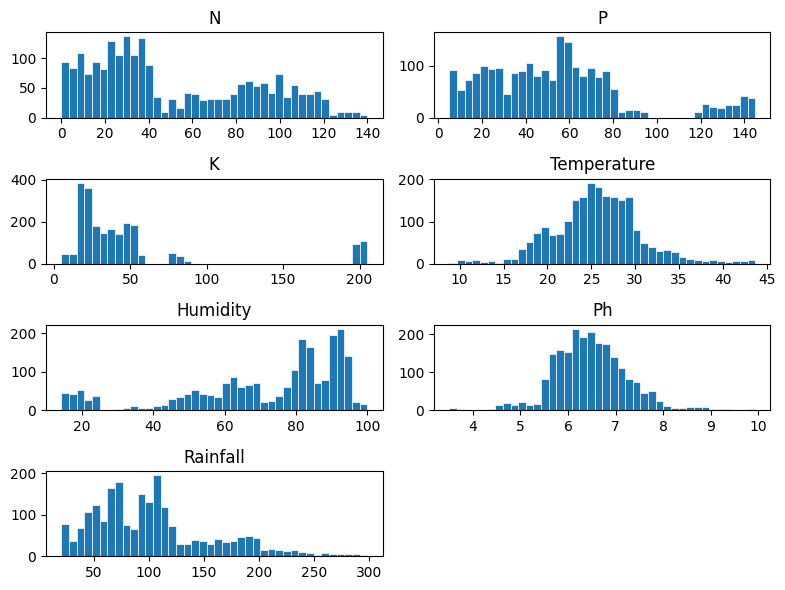

In [7]:
cols_df = [col for col in df_main.columns if df_main[col].dtype==np.float64 or df_main[col].dtype==np.int64]

nrows_ = int(len(df_main.columns) / 2)
ncols_ = int(nrows_ / 2)


plt.figure(figsize=(8, 6))
for i, col in enumerate(cols_df):
    plt.subplot(nrows_, ncols_, i+1)
    plt.hist(x=df_main[col], bins=40, linewidth=0.5, edgecolor="white")
    plt.title(f"{col.title()}")

plt.tight_layout()
plt.show()

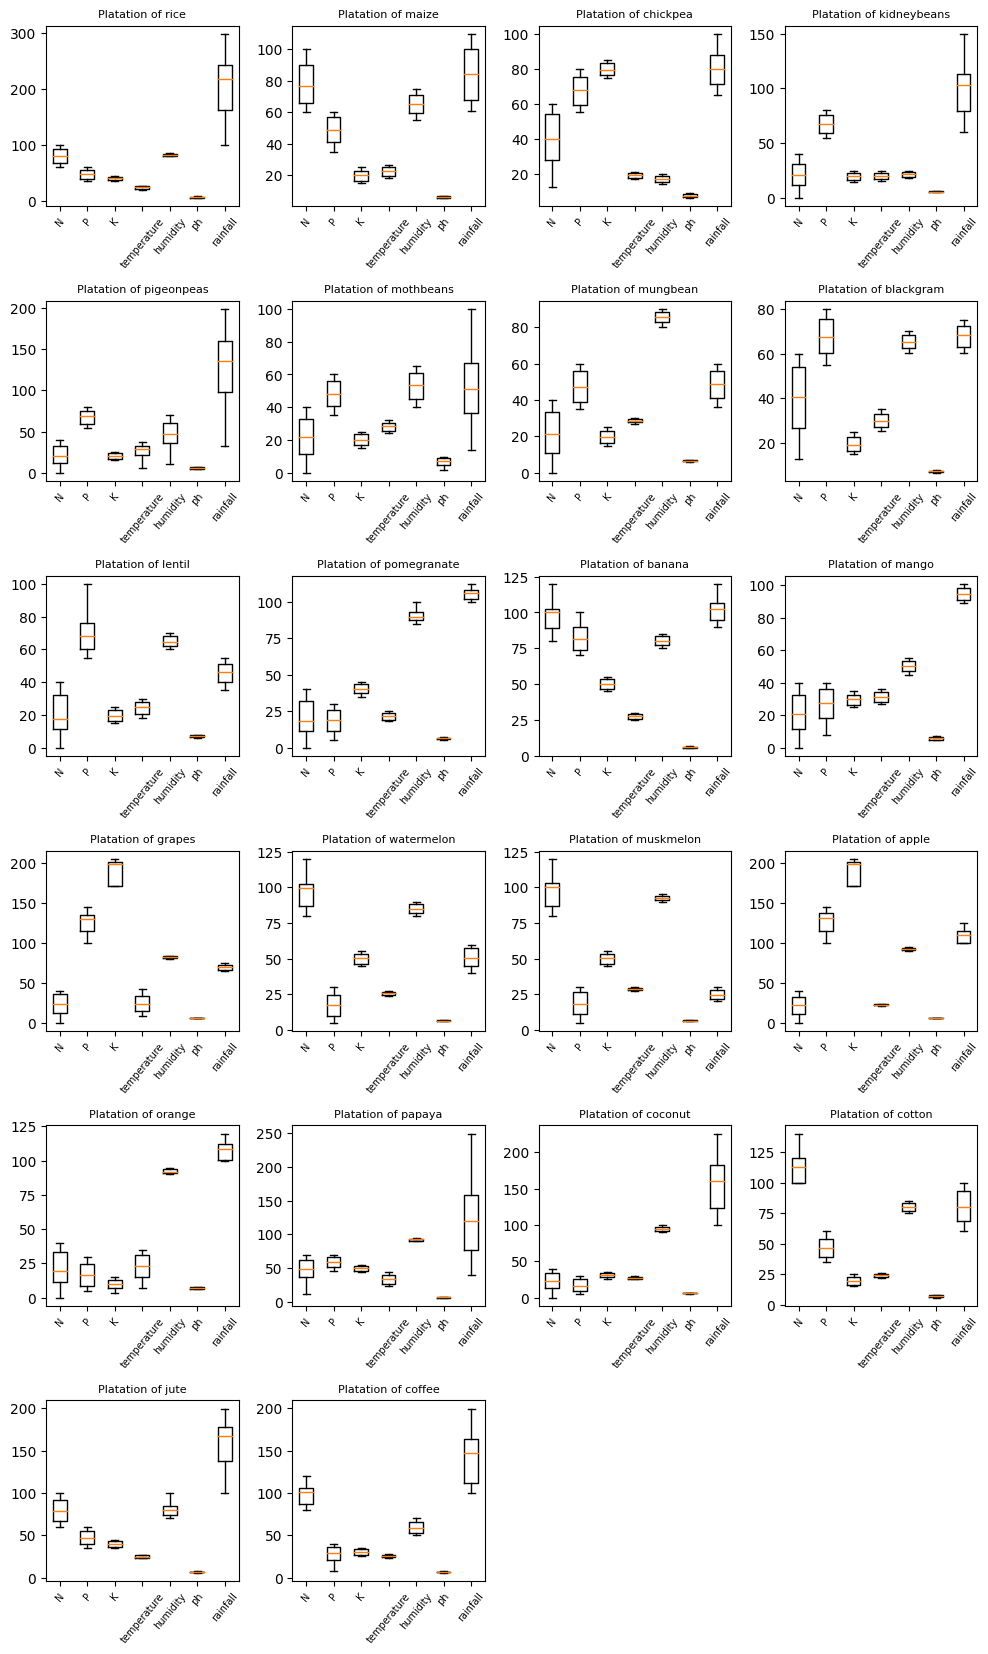

In [8]:
crop_types = df_main["label"].unique()

plt.figure(figsize=(10, 60))
for i, crop in enumerate(crop_types):
    base = list()
    df_base = df_main.query(f"label == '{crop}'").describe()
    for col in df_base.columns:
        base.append(df_base[col])

    plt.subplot(len(crop_types), 4, i+1)
    plt.boxplot(x=base, showfliers=False, labels=df_main.columns[:-1])
    plt.title(f"Platation of {crop}", fontdict={"size":"8"})
    plt.tick_params(axis="x", labelsize=7)
    plt.xticks(rotation=50)

plt.tight_layout()
plt.show()

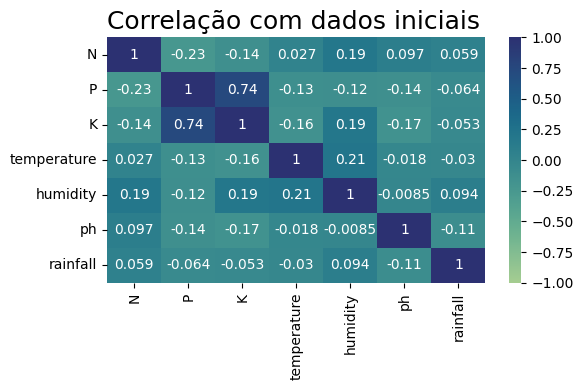

In [9]:
correlation = df_main.drop(["label"], axis=1).corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, vmax=1, vmin=-1,cmap="crest")
plt.title("Correlação com dados iniciais", fontdict={"size":"18"}, loc="left")
plt.tight_layout()
plt.show()

In [10]:
# n_factor = df_main.copy()
# n_factor["factor_N_temperature"] = n_factor["N"] / n_factor["temperature"]
# n_factor["factor_N_humidity"] = n_factor["N"] / n_factor["humidity"]
# n_factor["factor_N_ph"] = n_factor["N"] / n_factor["ph"]
# n_factor["factor_N"] = n_factor["N"] / n_factor["rainfall"]

# p_factor = df_main.copy()
# p_factor["factor_P_temperature"] = p_factor["P"] / p_factor["temperature"]
# p_factor["factor_P_humidity"] = p_factor["P"] / p_factor["humidity"]
# p_factor["factor_P_ph"] = p_factor["P"] / p_factor["ph"]
# p_factor["factor_P"] = p_factor["P"] / p_factor["rainfall"]

# k_factor = df_main.copy()
# k_factor["factor_K_temperature"] = k_factor["K"] / k_factor["temperature"]
# k_factor["factor_K_humidity"] = k_factor["K"] / k_factor["humidity"]
# k_factor["factor_K_ph"] = k_factor["K"] / k_factor["ph"]
# k_factor["factor_K"] = k_factor["K"] / k_factor["rainfall"]

### Plotting each variable with its target

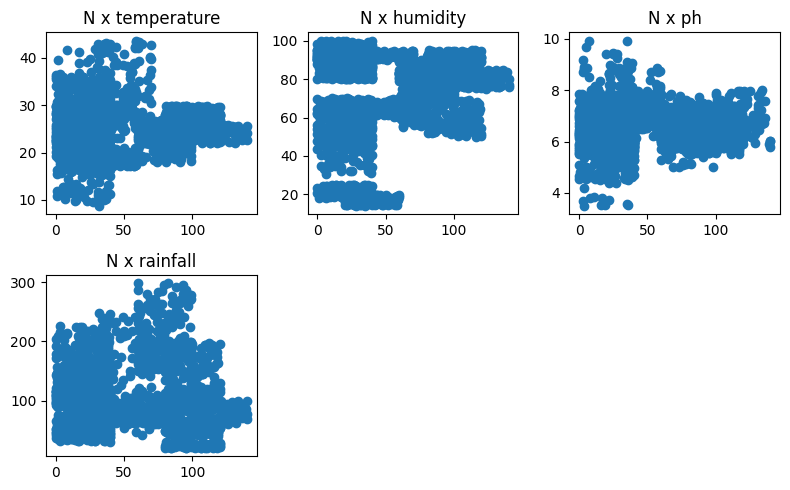

In [11]:
df_nitrate = df_main.drop(["P", "K"], axis=1)
plt.figure(figsize=(8, 5))
for i, col in enumerate(df_nitrate.drop(["N", "label"], axis=1).columns):
    plt.subplot(2, 3, i+1)
    plt.scatter(x=df_nitrate["N"], y=df_nitrate[col])
    plt.title(f"N x {col}")

plt.tight_layout()
plt.show()

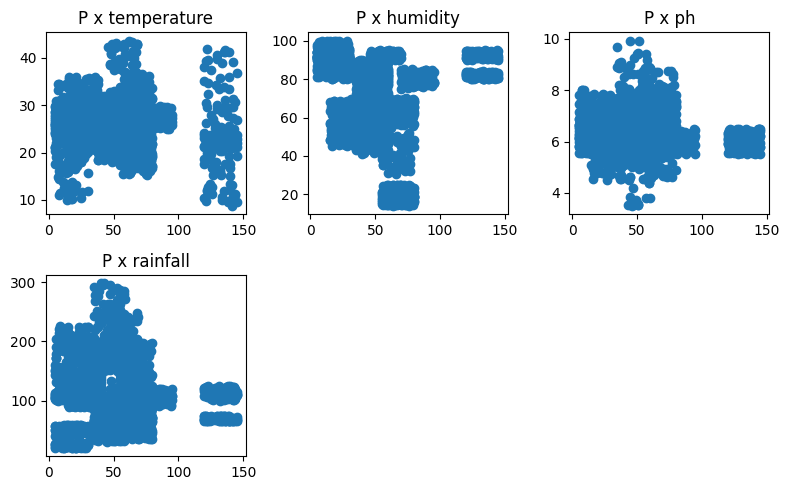

In [12]:
df_phosphate = df_main.drop(["N", "K"], axis=1)
plt.figure(figsize=(8, 5))
for i, col in enumerate(df_phosphate.drop(["P", "label"], axis=1).columns):
    plt.subplot(2, 3, i+1)
    plt.scatter(x=df_phosphate["P"], y=df_phosphate[col])
    plt.title(f"P x {col}")

plt.tight_layout()
plt.show()

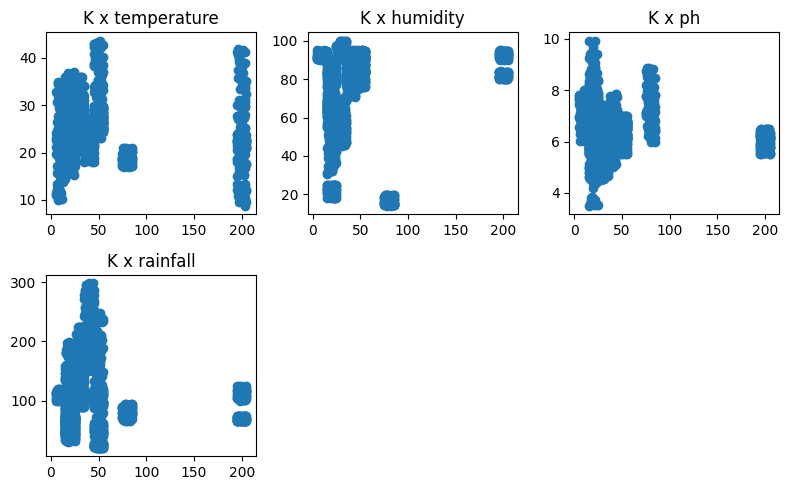

In [13]:
df_potassium = df_main.drop(["N", "P"], axis=1)
plt.figure(figsize=(8, 5))
for i, col in enumerate(df_potassium.drop(["K", "label"], axis=1).columns):
    plt.subplot(2, 3, i+1)
    plt.scatter(x=df_potassium["K"], y=df_potassium[col])
    plt.title(f"K x {col}")

plt.tight_layout()
plt.show()

It's clear that there are no linear relations among the variables and the targets

In this case, I'll try to make a log transformation or even a squared transoformation in case the log is not enough

#### LOG Transformation

In [14]:
df_log = df_main.copy()
df_log["temperature"] = np.log(df_log["temperature"])
df_log["humidity"] = np.log(df_log["humidity"])
df_log["ph"] = np.log(df_log["ph"])
df_log["rainfall"] = np.log(df_log["rainfall"])

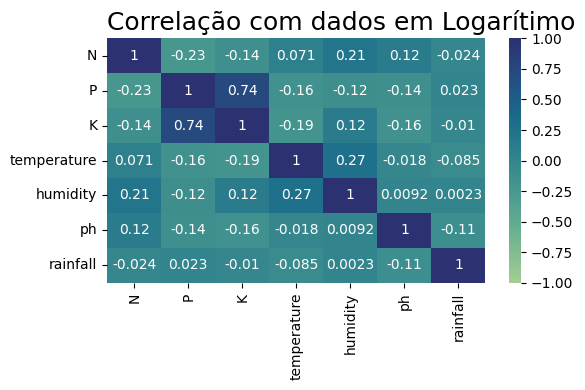

In [15]:
correlation_log = df_log.drop(["label"], axis=1).corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_log, annot=True, vmax=1, vmin=-1,cmap="crest")
plt.title("Correlação com dados em Logarítimo", fontdict={"size":"18"}, loc="left")
plt.tight_layout()
plt.show()

The log tranformation improved the relation among the variables, but it's got a small increase\
It'll be required making the exponential analysis.

#### Exponential Transformation

In [16]:
df_sqr = df_main.copy()
df_sqr["temperature"] = np.square(df_sqr["temperature"])
df_sqr["humidity"] = np.square(df_sqr["humidity"])
df_sqr["ph"] = np.square(df_sqr["ph"])
df_sqr["rainfall"] = np.square(df_sqr["rainfall"])

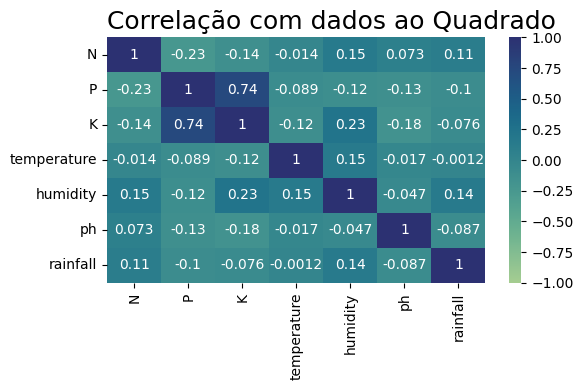

In [17]:
correlation_sqr = df_sqr.drop(["label"], axis=1).corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_sqr, annot=True, vmax=1, vmin=-1,cmap="crest")
plt.title("Correlação com dados ao Quadrado", fontdict={"size":"18"}, loc="left")
plt.tight_layout()
plt.show()

### Separating data for data

#### Current Data

In [18]:
cols_descriptive = ["temperature", "humidity", "ph", "rainfall"]

X = df_main.loc[:, cols_descriptive]
y_N = df_main.loc[:, "N"]
y_P = df_main.loc[:, "P"]
y_K = df_main.loc[:, "K"]

In [19]:
model_analysis_base_N = sm.OLS(y_N, X)
model_analysis_base_P = sm.OLS(y_P, X)
model_analysis_base_K = sm.OLS(y_K, X)

results_base_N = model_analysis_base_N.fit()
results_base_P = model_analysis_base_P.fit()
results_base_K = model_analysis_base_K.fit()

In [20]:
results_base_N.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      N   R-squared (uncentered):                   0.669
Model:                            OLS   Adj. R-squared (uncentered):              0.669
Method:                 Least Squares   F-statistic:                              1111.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:42:18   Log-Likelihood:                         -11005.
No. Observations:                2200   AIC:                                  2.202e+04
Df Residuals:                    2196   BIC:                                  2.204e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    -0.1146      0.138     -0.828      0.408      -0.386       0.157
humidity        0.3077      0.035      8.834      0.000       0.239       0.376
ph              4.3572      0.560      7.778      0.000       3.259       5.456
rainfall        0.0325      0.014      2.377      0.018       0.006       0.059
==============================================================================
Omnibus:                      536.390   Durbin-Watson:                   0.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.275
Skew:                           0.416   Prob(JB):                     3.16e-34
Kurtosis:                       2.004   Cond. No.                         102.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
results_base_P.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      P   R-squared (uncentered):                   0.700
Model:                            OLS   Adj. R-squared (uncentered):              0.700
Method:                 Least Squares   F-statistic:                              1282.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:42:18   Log-Likelihood:                         -10902.
No. Observations:                2200   AIC:                                  2.181e+04
Df Residuals:                    2196   BIC:                                  2.183e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     0.3685      0.132      2.791      0.005       0.110       0.627
humidity       -0.0281      0.033     -0.846      0.398      -0.093       0.037
ph              6.7053      0.534     12.547      0.000       5.657       7.753
rainfall        0.0136      0.013      1.041      0.298      -0.012       0.039
==============================================================================
Omnibus:                      362.904   Durbin-Watson:                   0.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              572.346
Skew:                           1.132   Prob(JB):                    5.21e-125
Kurtosis:                       4.057   Cond. No.                         102.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
results_base_K.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      K   R-squared (uncentered):                   0.494
Model:                            OLS   Adj. R-squared (uncentered):              0.493
Method:                 Least Squares   F-statistic:                              536.8
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                   3.46e-323
Time:                        19:42:18   Log-Likelihood:                         -11714.
No. Observations:                2200   AIC:                                  2.344e+04
Df Residuals:                    2196   BIC:                                  2.346e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    -0.8511      0.191     -4.456      0.000      -1.226      -0.477
humidity        0.6777      0.048     14.099      0.000       0.583       0.772
ph              3.5195      0.773      4.552      0.000       2.003       5.036
rainfall       -0.0254      0.019     -1.348      0.178      -0.062       0.012
==============================================================================
Omnibus:                      827.162   Durbin-Watson:                   0.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2406.980
Skew:                           2.006   Prob(JB):                         0.00
Kurtosis:                       6.187   Cond. No.                         102.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Log Data

In [23]:
cols_descriptive = ["temperature", "humidity", "ph", "rainfall"]

X_log = df_log.loc[:, cols_descriptive]
y_N = df_log.loc[:, "N"]
y_P = df_log.loc[:, "P"]
y_K = df_log.loc[:, "K"]

In [24]:
model_analysis_base_N = sm.OLS(y_N, X_log)
model_analysis_base_P = sm.OLS(y_P, X_log)
model_analysis_base_K = sm.OLS(y_K, X_log)

results_base_N = model_analysis_base_N.fit()
results_base_P = model_analysis_base_P.fit()
results_base_K = model_analysis_base_K.fit()

In [25]:
results_base_N.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      N   R-squared (uncentered):                   0.669
Model:                            OLS   Adj. R-squared (uncentered):              0.668
Method:                 Least Squares   F-statistic:                              1109.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:42:18   Log-Likelihood:                         -11006.
No. Observations:                2200   AIC:                                  2.202e+04
Df Residuals:                    2196   BIC:                                  2.204e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    -7.5866      3.109     -2.440      0.015     -13.683      -1.490
humidity       14.9516      1.731      8.637      0.000      11.557      18.346
ph             15.4073      4.765      3.233      0.001       6.063      24.752
rainfall       -3.5978      1.258     -2.860      0.004      -6.065      -1.131
==============================================================================
Omnibus:                      746.487   Durbin-Watson:                   0.240
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.028
Skew:                           0.381   Prob(JB):                     7.97e-35
Kurtosis:                       1.936   Cond. No.                         48.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
results_base_P.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      P   R-squared (uncentered):                   0.718
Model:                            OLS   Adj. R-squared (uncentered):              0.718
Method:                 Least Squares   F-statistic:                              1399.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:42:18   Log-Likelihood:                         -10834.
No. Observations:                2200   AIC:                                  2.168e+04
Df Residuals:                    2196   BIC:                                  2.170e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     3.6564      2.875      1.272      0.204      -1.981       9.294
humidity       -2.4152      1.601     -1.509      0.131      -5.554       0.724
ph             10.8995      4.406      2.474      0.013       2.259      19.540
rainfall        6.9129      1.163      5.943      0.000       4.632       9.194
==============================================================================
Omnibus:                      344.752   Durbin-Watson:                   0.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              533.228
Skew:                           1.092   Prob(JB):                    1.63e-116
Kurtosis:                       4.025   Cond. No.                         48.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
results_base_K.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      K   R-squared (uncentered):                   0.496
Model:                            OLS   Adj. R-squared (uncentered):              0.495
Method:                 Least Squares   F-statistic:                              540.7
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:42:18   Log-Likelihood:                         -11710.
No. Observations:                2200   AIC:                                  2.343e+04
Df Residuals:                    2196   BIC:                                  2.345e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature   -25.9065      4.281     -6.051      0.000     -34.302     -17.511
humidity       26.6108      2.384     11.163      0.000      21.936      31.285
ph             -2.3161      6.562     -0.353      0.724     -15.184      10.552
rainfall        5.3214      1.732      3.072      0.002       1.924       8.719
==============================================================================
Omnibus:                      863.394   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2619.089
Skew:                           2.082   Prob(JB):                         0.00
Kurtosis:                       6.351   Cond. No.                         48.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Squared Data

In [28]:
cols_descriptive = ["temperature", "humidity", "ph", "rainfall"]

X_sqr = df_sqr.loc[:, cols_descriptive]
y_N = df_sqr.loc[:, "N"]
y_P = df_sqr.loc[:, "P"]
y_K = df_sqr.loc[:, "K"]

In [29]:
model_analysis_base_N = sm.OLS(y_N, X_sqr)
model_analysis_base_P = sm.OLS(y_P, X_sqr)
model_analysis_base_K = sm.OLS(y_K, X_sqr)

results_base_N = model_analysis_base_N.fit()
results_base_P = model_analysis_base_P.fit()
results_base_K = model_analysis_base_K.fit()

In [30]:
results_base_N.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      N   R-squared (uncentered):                   0.660
Model:                            OLS   Adj. R-squared (uncentered):              0.660
Method:                 Least Squares   F-statistic:                              1068.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:42:18   Log-Likelihood:                         -11034.
No. Observations:                2200   AIC:                                  2.208e+04
Df Residuals:                    2196   BIC:                                  2.210e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     0.0029      0.003      1.080      0.280      -0.002       0.008
humidity        0.0026      0.000      9.355      0.000       0.002       0.003
ph              0.6839      0.046     14.787      0.000       0.593       0.775
rainfall        0.0003   5.23e-05      5.623      0.000       0.000       0.000
==============================================================================
Omnibus:                      386.840   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.714
Skew:                           0.425   Prob(JB):                     6.21e-32
Kurtosis:                       2.080   Cond. No.                     1.23e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
results_base_P.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      P   R-squared (uncentered):                   0.668
Model:                            OLS   Adj. R-squared (uncentered):              0.667
Method:                 Least Squares   F-statistic:                              1104.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:42:18   Log-Likelihood:                         -11015.
No. Observations:                2200   AIC:                                  2.204e+04
Df Residuals:                    2196   BIC:                                  2.206e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     0.0170      0.003      6.466      0.000       0.012       0.022
humidity        0.0008      0.000      2.904      0.004       0.000       0.001
ph              0.8082      0.046     17.629      0.000       0.718       0.898
rainfall    -5.947e-06   5.19e-05     -0.115      0.909      -0.000    9.57e-05
==============================================================================
Omnibus:                      281.433   Durbin-Watson:                   0.187
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              396.648
Skew:                           0.987   Prob(JB):                     7.40e-87
Kurtosis:                       3.658   Cond. No.                     1.23e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
results_base_K.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      K   R-squared (uncentered):                   0.491
Model:                            OLS   Adj. R-squared (uncentered):              0.490
Method:                 Least Squares   F-statistic:                              529.3
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                   7.17e-320
Time:                        19:42:18   Log-Likelihood:                         -11722.
No. Observations:                2200   AIC:                                  2.345e+04
Df Residuals:                    2196   BIC:                                  2.347e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    -0.0060      0.004     -1.654      0.098      -0.013       0.001
humidity        0.0069      0.000     18.119      0.000       0.006       0.008
ph              0.3275      0.063      5.180      0.000       0.204       0.452
rainfall       -0.0002   7.15e-05     -3.392      0.001      -0.000      -0.000
==============================================================================
Omnibus:                      753.922   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1992.751
Skew:                           1.864   Prob(JB):                         0.00
Kurtosis:                       5.799   Cond. No.                     1.23e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Scalling Data

In [33]:
cols_descriptive = ["temperature", "humidity", "ph", "rainfall"]

scaller = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaller.transform(X)

y_N = df_sqr.loc[:, "N"]
y_P = df_sqr.loc[:, "P"]
y_K = df_sqr.loc[:, "K"]

In [34]:
model_analysis_base_N = sm.OLS(y_N, X_scaled)
model_analysis_base_P = sm.OLS(y_P, X_scaled)
model_analysis_base_K = sm.OLS(y_K, X_scaled)

results_base_N = model_analysis_base_N.fit()
results_base_P = model_analysis_base_P.fit()
results_base_K = model_analysis_base_K.fit()

In [35]:
results_base_N.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      N   R-squared (uncentered):                   0.667
Model:                            OLS   Adj. R-squared (uncentered):              0.667
Method:                 Least Squares   F-statistic:                              1101.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:42:18   Log-Likelihood:                         -11012.
No. Observations:                2200   AIC:                                  2.203e+04
Df Residuals:                    2196   BIC:                                  2.205e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.7065      4.660      1.654      0.098      -1.431      16.844
x2            30.0270      2.909     10.321      0.000      24.322      35.732
x3            47.8510      4.627     10.341      0.000      38.776      56.926
x4            14.2567      3.744      3.807      0.000       6.914      21.600
==============================================================================
Omnibus:                      503.810   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.038
Skew:                           0.388   Prob(JB):                     5.28e-32
Kurtosis:                       2.015   Cond. No.                         7.60
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
results_base_P.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      P   R-squared (uncentered):                   0.670
Model:                            OLS   Adj. R-squared (uncentered):              0.669
Method:                 Least Squares   F-statistic:                              1112.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:42:18   Log-Likelihood:                         -11009.
No. Observations:                2200   AIC:                                  2.203e+04
Df Residuals:                    2196   BIC:                                  2.205e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            33.1977      4.654      7.133      0.000      24.070      42.325
x2             7.9238      2.906      2.727      0.006       2.225      13.623
x3            54.3737      4.622     11.763      0.000      45.309      63.438
x4            14.1103      3.740      3.772      0.000       6.775      21.445
==============================================================================
Omnibus:                      296.340   Durbin-Watson:                   0.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              425.413
Skew:                           1.017   Prob(JB):                     4.20e-93
Kurtosis:                       3.708   Cond. No.                         7.60
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
results_base_K.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      K   R-squared (uncentered):                   0.482
Model:                            OLS   Adj. R-squared (uncentered):              0.481
Method:                 Least Squares   F-statistic:                              510.1
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                   2.54e-311
Time:                        19:42:18   Log-Likelihood:                         -11742.
No. Observations:                2200   AIC:                                  2.349e+04
Df Residuals:                    2196   BIC:                                  2.351e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -16.3615      6.493     -2.520      0.012     -29.095      -3.628
x2            66.8088      4.054     16.479      0.000      58.858      74.759
x3            18.5471      6.448      2.876      0.004       5.901      31.193
x4             0.3011      5.218      0.058      0.954      -9.932      10.534
==============================================================================
Omnibus:                      786.423   Durbin-Watson:                   0.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2130.183
Skew:                           1.943   Prob(JB):                         0.00
Kurtosis:                       5.853   Cond. No.                         7.60
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### New Strategy

 ***** Explaining the new strategy *****

The new strategy is based on making a prediction of one term N and then, the N predicted,
becames a descriptive variable of P, and the P becames a descriptive of K.\
The idea here is to evaluate which target will become descriptive of the other.

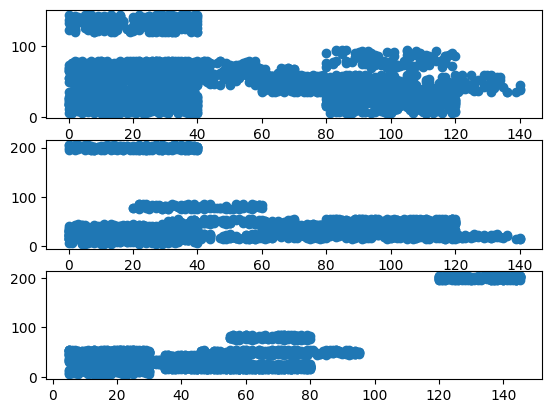

In [38]:
fig, axes = plt.subplots(3)
axes[0].scatter(x=df_log["N"], y=df_log["P"])
axes[1].scatter(x=df_log["N"], y=df_log["K"])
axes[2].scatter(x=df_log["P"], y=df_log["K"])
plt.show()

#### Evaluating N

In [39]:
cols_descriptive = ["P", "temperature", "humidity", "ph", "rainfall"]

X = df_log.loc[:, cols_descriptive]
y = df_log.loc[:, "N"]

model_analysis_base_N = sm.OLS(y, X)

results_base_N = model_analysis_base_N.fit()

In [40]:
results_base_N.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      N   R-squared (uncentered):                   0.684
Model:                            OLS   Adj. R-squared (uncentered):              0.684
Method:                 Least Squares   F-statistic:                              952.3
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:42:18   Log-Likelihood:                         -10953.
No. Observations:                2200   AIC:                                  2.192e+04
Df Residuals:                    2195   BIC:                                  2.195e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
P              -0.2343      0.023    -10.400      0.000      -0.279      -0.190
temperature    -6.7298      3.037     -2.216      0.027     -12.685      -0.774
humidity       14.3856      1.691      8.506      0.000      11.069      17.702
ph             17.9616      4.659      3.855      0.000       8.824      27.099
rainfall       -1.9778      1.238     -1.597      0.110      -4.406       0.451
==============================================================================
Omnibus:                      346.184   Durbin-Watson:                   0.255
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.233
Skew:                           0.261   Prob(JB):                     6.32e-23
Kurtosis:                       2.082   Cond. No.                         427.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Clearly the prediction of N is well represented by all other variables and also P.\
In this case, K didn't have a good representation on the prediction

#### Evaluating P

In [41]:
cols_descriptive = ["temperature", "humidity", "ph", "rainfall"]

X = df_log.loc[:, cols_descriptive]
y = df_log.loc[:, "P"]

model_analysis_base_P = sm.OLS(y, X)

results_base_P = model_analysis_base_P.fit()

results_base_P.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      P   R-squared (uncentered):                   0.718
Model:                            OLS   Adj. R-squared (uncentered):              0.718
Method:                 Least Squares   F-statistic:                              1399.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:42:18   Log-Likelihood:                         -10834.
No. Observations:                2200   AIC:                                  2.168e+04
Df Residuals:                    2196   BIC:                                  2.170e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     3.6564      2.875      1.272      0.204      -1.981       9.294
humidity       -2.4152      1.601     -1.509      0.131      -5.554       0.724
ph             10.8995      4.406      2.474      0.013       2.259      19.540
rainfall        6.9129      1.163      5.943      0.000       4.632       9.194
==============================================================================
Omnibus:                      344.752   Durbin-Watson:                   0.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              533.228
Skew:                           1.092   Prob(JB):                    1.63e-116
Kurtosis:                       4.025   Cond. No.                         48.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

N's coefient is very low, eventhough it had a small P-value.\
In this case, as N depends on P already, I'll takie N from the prediction of P, to avoid circular reference

Taking N out of the model didn't have great impact on model's performance.

#### Evaluating K

In [42]:
cols_descriptive = ["P", "temperature", "humidity", "ph", "rainfall"]

X = df_log.loc[:, cols_descriptive]
y = df_log.loc[:, "K"]

model_analysis_base_P = sm.OLS(y, X)

results_base_P = model_analysis_base_P.fit()

results_base_P.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      K   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              1707.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:42:18   Log-Likelihood:                         -10719.
No. Observations:                2200   AIC:                                  2.145e+04
Df Residuals:                    2195   BIC:                                  2.148e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
P               1.1478      0.020     56.675      0.000       1.108       1.188
temperature   -30.1034      2.729    -11.029      0.000     -35.456     -24.751
humidity       29.3831      1.520     19.332      0.000      26.402      32.364
ph            -14.8270      4.188     -3.541      0.000     -23.039      -6.615
rainfall       -2.6135      1.113     -2.348      0.019      -4.796      -0.431
==============================================================================
Omnibus:                      373.036   Durbin-Watson:                   0.233
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.822
Skew:                           0.202   Prob(JB):                     1.56e-21
Kurtosis:                       2.061   Cond. No.                         427.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The representativeness of N for predicting K, was not good. So we can take it out of the model

### Conclusion of Evaluation

For this model, the first target to be predicet will be P (Phosphate), which will predict both other variables (K (Potassium), N (Nitrate)) 

## Creating Models - P

### Separating Data for P

In [43]:
cols_descriptive = ["temperature", "humidity", "ph", "rainfall"]

X_p = df_log.loc[:, cols_descriptive]
y_p = df_log.loc[:, "P"]

X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, test_size=0.2)

### Linear Regression

In [44]:
model_lr_P_v01 = LinearRegression()
model_lr_P_v01.fit(X_train, y_train)

result_lr_P_v01_train = model_lr_P_v01.predict(X_train)
result_lr_P_v01_test = model_lr_P_v01.predict(X_test)

print(r2_score(y_train, result_lr_P_v01_train))
print(r2_score(y_test, result_lr_P_v01_test))

0.05193111369377279
0.0520308548272147


In [45]:
model_lr_P_v02 = sm.OLS(y_p, X_p)
model_lr_P_v02 = model_lr_P_v02.fit()

result_lr_P_v02_train = model_lr_P_v02.predict(X_train)
result_lr_P_v02_test = model_lr_P_v02.predict(X_test)

print(r2_score(y_train, result_lr_P_v02_train))
print(r2_score(y_test, result_lr_P_v02_test))

-0.019981875629026202
-0.01929021382990137


On the assumption that the model is not linear, we didn't have a good performance with linear models.\
Let's continue with non Linear models

### Decision Tree Regression

In [46]:
model_dtr_P_v01 = DecisionTreeRegressor()
model_dtr_P_v01.fit(X_train, y_train)

result_dtr_P_v01_train = model_dtr_P_v01.predict(X_train)
result_dtr_P_v01_test = model_dtr_P_v01.predict(X_test)

r2_treino = r2_score(y_train, result_dtr_P_v01_train)
r2_teste = r2_score(y_test, result_dtr_P_v01_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 1.0
Test Performance: 0.6633648916244606


In [47]:
model_dtr_P_v02 = DecisionTreeRegressor(max_depth=5)
model_dtr_P_v02.fit(X_train, y_train)

result_dtr_P_v02_train = model_dtr_P_v02.predict(X_train)
result_dtr_P_v02_test = model_dtr_P_v02.predict(X_test)

r2_treino = r2_score(y_train, result_dtr_P_v02_train)
r2_teste = r2_score(y_test, result_dtr_P_v02_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.6781729273515815
Test Performance: 0.5860001840527869


In [48]:
model_dtr_P_v03 = DecisionTreeRegressor(max_depth=15)
model_dtr_P_v03.fit(X_train, y_train)

result_dtr_P_v03_train = model_dtr_P_v03.predict(X_train)
result_dtr_P_v03_test = model_dtr_P_v03.predict(X_test)

r2_treino = r2_score(y_train, result_dtr_P_v03_train)
r2_teste = r2_score(y_test, result_dtr_P_v03_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.9961302405387803
Test Performance: 0.5814120879877609


In [49]:
model_dtr_P_v04 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=3) # The min samples leaf default is 2. I'll increase it to 3 and see what happens
model_dtr_P_v04.fit(X_train, y_train)

result_dtr_P_v04_train = model_dtr_P_v04.predict(X_train)
result_dtr_P_v04_test = model_dtr_P_v04.predict(X_test)

r2_treino = r2_score(y_train, result_dtr_P_v04_train)
r2_teste = r2_score(y_test, result_dtr_P_v04_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

# great achieviment increasing min_samples_leaf

Training Performance: 0.9311337022075608
Test Performance: 0.691088606585446


In [50]:
model_dtr_P_v05 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=10)
model_dtr_P_v05.fit(X_train, y_train)

result_dtr_P_v05_train = model_dtr_P_v05.predict(X_train)
result_dtr_P_v05_test = model_dtr_P_v05.predict(X_test)

r2_treino = r2_score(y_train, result_dtr_P_v05_train)
r2_teste = r2_score(y_test, result_dtr_P_v05_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.848762493274168
Test Performance: 0.7040270301026272


Best model was Version 5

### Random Forest Regressor

In [51]:
model_rfr_P_v01 = RandomForestRegressor()
model_rfr_P_v01.fit(X_train, y_train)

result_rfr_P_v01_train = model_rfr_P_v01.predict(X_train)
result_rfr_P_v01_test = model_rfr_P_v01.predict(X_test)

r2_treino = r2_score(y_train, result_rfr_P_v01_train)
r2_teste = r2_score(y_test, result_rfr_P_v01_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.9715765718741266
Test Performance: 0.7815390352651127


In [52]:
model_rfr_P_v02 = RandomForestRegressor(n_estimators=80)
# with 80 estimator, the model runs faster, and doesn't lose much performance
model_rfr_P_v02.fit(X_train, y_train)

result_rfr_P_v02_train = model_rfr_P_v02.predict(X_train)
result_rfr_P_v02_test = model_rfr_P_v02.predict(X_test)

r2_treino = r2_score(y_train, result_rfr_P_v02_train)
r2_teste = r2_score(y_test, result_rfr_P_v02_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.9707671102181851
Test Performance: 0.7732796409187399


In [53]:
model_rfr_P_v03 = RandomForestRegressor(n_estimators=80, max_depth=30)
# with 80 estimator, the model runs faster, and doesn't lose much performance
model_rfr_P_v03.fit(X_train, y_train)

result_rfr_P_v03_train = model_rfr_P_v03.predict(X_train)
result_rfr_P_v03_test = model_rfr_P_v03.predict(X_test)

r2_treino = r2_score(y_train, result_rfr_P_v03_train)
r2_teste = r2_score(y_test, result_rfr_P_v03_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.9717962036936536
Test Performance: 0.7787856145004733


In [54]:
model_rfr_P_v04 = RandomForestRegressor(n_estimators=80, max_depth=50)
# with 80 estimator, the model runs faster, and doesn't lose much performance
model_rfr_P_v04.fit(X_train, y_train)

result_rfr_P_v04_train = model_rfr_P_v04.predict(X_train)
result_rfr_P_v04_test = model_rfr_P_v04.predict(X_test)

r2_treino = r2_score(y_train, result_rfr_P_v04_train)
r2_teste = r2_score(y_test, result_rfr_P_v04_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.969788243219736
Test Performance: 0.7721446177825487


In [55]:
model_rfr_P_v05 = RandomForestRegressor(n_estimators=80, max_depth=50, min_samples_leaf=10)
# with 80 estimator, the model runs faster, and doesn't lose much performance
model_rfr_P_v05.fit(X_train, y_train)

result_rfr_P_v05_train = model_rfr_P_v05.predict(X_train)
result_rfr_P_v05_test = model_rfr_P_v05.predict(X_test)

r2_treino = r2_score(y_train, result_rfr_P_v05_train)
r2_teste = r2_score(y_test, result_rfr_P_v05_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.8394227522270925
Test Performance: 0.726390777509359


Best model was Version 01

### XGBoost Regressor

In [56]:
model_xgb_P_v01 = xgb.XGBRegressor()
model_xgb_P_v01.fit(X_train, y_train)

result_xgb_P_v01_train = model_xgb_P_v01.predict(X_train)
result_xgb_P_v01_test = model_xgb_P_v01.predict(X_test)

r2_treino = r2_score(y_train, result_xgb_P_v01_train)
r2_teste = r2_score(y_test, result_xgb_P_v01_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.9916177936110798
Test Performance: 0.7750676351781864


In [57]:
model_xgb_P_v02 = xgb.XGBRegressor(n_estimators=80, max_depth=5)
model_xgb_P_v02.fit(X_train, y_train)

result_xgb_P_v02_train = model_xgb_P_v02.predict(X_train)
result_xgb_P_v02_test = model_xgb_P_v02.predict(X_test)

r2_treino = r2_score(y_train, result_xgb_P_v02_train)
r2_teste = r2_score(y_test, result_xgb_P_v02_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.9702888648369842
Test Performance: 0.7784838605211666


In [58]:
model_xgb_P_v03 = xgb.XGBRegressor(n_estimators=80, max_depth=5, n_jobs=1000)
model_xgb_P_v03.fit(X_train, y_train)

result_xgb_P_v03_train = model_xgb_P_v03.predict(X_train)
result_xgb_P_v03_test = model_xgb_P_v03.predict(X_test)

r2_treino = r2_score(y_train, result_xgb_P_v03_train)
r2_teste = r2_score(y_test, result_xgb_P_v03_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.9702888648369842
Test Performance: 0.7784838605211666


Best model was Version 1

### Conclusion for P

The conclusion for P models is that we cannot use linear models to predict this factor.\
In this case I tried other non linear methods and achieved a good performance of prediction.\

For P, I'll continue with the RandomForestRegressor, because it was the best regressor in test

## Creating Models - N

#### Separating data for N

In [59]:
cols_descriptive = ["P", "temperature", "humidity", "ph", "rainfall"]

X_n = df_log.loc[:, cols_descriptive]
y_n = df_log.loc[:, "N"]

X_train, X_test, y_train, y_test = train_test_split(X_n, y_n, test_size=0.2)

As long as we know these data are not linearly distribuited, there is no need to create linear models for testing.\
In this case, I'll simply jump this part of testing linear models, different from the previous component "P"

#### Decision Tree Regression

In [60]:
model_dtr_N_v01 = DecisionTreeRegressor()
model_dtr_N_v01.fit(X_train, y_train)

result_dtr_N_v01_train = model_dtr_N_v01.predict(X_train)
result_dtr_N_v01_test = model_dtr_N_v01.predict(X_test)

r2_treino = r2_score(y_train, result_dtr_N_v01_train)
r2_teste = r2_score(y_test, result_dtr_N_v01_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 1.0
Test Performance: 0.7362268777460905


In [61]:
# Creating GridSearch model
params_dtr = {
    "criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"],
    "splitter":["best", "random"],
    "max_depth":[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
    "min_samples_split":[2, 3, 4, 5],
    "min_samples_leaf":[1, 2, 3, 4]
}

In [62]:
model_dtr_N_grid = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=params_dtr)
model_dtr_N_grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16,
                                       18, 20],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5],
                         'splitter': ['best', 'random']})

In [63]:
print(f"Best Params: {model_dtr_N_grid.best_params_}")
print(f"Best score: {model_dtr_N_grid.best_score_}")

Best Params: {'criterion': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
Best score: 0.8099765535102431


In [64]:
model_dtr_N = DecisionTreeRegressor(
    criterion="poisson",
    max_depth=8,
    min_samples_split=3,
    min_samples_leaf=1,
    splitter="best"
)
model_dtr_N.fit(X_train, y_train)

result_dtr_N_train = model_dtr_N.predict(X_train)
result_dtr_N_test = model_dtr_N.predict(X_test)

r2_treino = r2_score(y_train, result_dtr_N_train)
r2_teste = r2_score(y_test, result_dtr_N_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.9111573806794181
Test Performance: 0.8243689976465699


#### Random Forest Regressor

In [137]:
# Creating GridSearch model
params_rfr= {
    "n_estimators":[80, 100, 120],
    "criterion":["squared_error", "absolute_error", "poisson"],
    "max_depth":[2, 3, 4, 5],
    "min_samples_split":[2, 3, 4],
    "min_samples_leaf":[1, 2, 3]
}

In [138]:
# model_rfr_N_grid = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params_rfr)
# model_rfr_N_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [80, 100, 120]})

In [139]:
# print(f"Best Params: {model_rfr_N_grid.best_params_}")
# print(f"Best score: {model_rfr_N_grid.best_score_}")

# Best Params: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 80}
# Best score: 0.716971579490249

Best Params: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 80}
Best score: 0.716971579490249


The training of RandomForestRegressor with gridSearchCV took around 25 minutes.\
Although it has more time of training, there wasn't a higher performance than DecisionTreeRegressor

#### XGBoost Regressor

In [68]:
param_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

In [70]:
model_xgb_N_grid = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_xgb)
model_xgb_N_grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]})

In [71]:
print(f"Best Params: {model_xgb_N_grid.best_params_}")
print(f"Best score: {model_xgb_N_grid.best_score_}")

Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best score: 0.8397012218498732


In [72]:
model_xgb_N = xgb.XGBRegressor(
    learning_rate=0.1, max_depth=5, n_estimators=100
)
model_xgb_N.fit(X_train, y_train)

result_xgb_N_train = model_xgb_N.predict(X_train)
result_xgb_N_test = model_xgb_N.predict(X_test)

r2_treino = r2_score(y_train, result_xgb_N_train)
r2_teste = r2_score(y_test, result_xgb_N_test)

print(f"Training Performance: {r2_treino}")
print(f"Test Performance: {r2_teste}")

Training Performance: 0.9325411180443891
Test Performance: 0.8496831568482273


#### Conclusion for N

For component 'N' - XGBoost Regressor had the best performance. It means these one will be a good candidate to the final model

## Creating Models - K

#### Separating data for K

In [73]:
cols_descriptive = ["N", "P", "temperature", "humidity", "ph", "rainfall"]

X_n = df_log.loc[:, cols_descriptive]
y_n = df_log.loc[:, "K"]

X_train, X_test, y_train, y_test = train_test_split(X_n, y_n, test_size=0.2)

In [75]:
# Creating GridSearch model
params_dtr = {
    "criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"],
    "splitter":["best", "random"],
    "max_depth":[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
    "min_samples_split":[2, 3, 4, 5],
    "min_samples_leaf":[1, 2, 3, 4]
}

In [76]:
model_dtr_K_grid = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=params_dtr)
model_dtr_K_grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16,
                                       18, 20],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5],
                         'splitter': ['best', 'random']})

In [77]:
print(f"Best Params: {model_dtr_K_grid.best_params_}")
print(f"Best score: {model_dtr_K_grid.best_score_}")

Best Params: {'criterion': 'poisson', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'random'}
Best score: 0.9856338976538342


#### XGBoost Regressor

In [78]:
param_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

In [79]:
model_xgb_K_grid = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_xgb)
model_xgb_K_grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]})

In [80]:
print(f"Best Params: {model_xgb_K_grid.best_params_}")
print(f"Best score: {model_xgb_K_grid.best_score_}")

Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best score: 0.9893582842051696


#### Conclusion for K

XGBoost Regressor also had the best performance here. We can conclude that we're to use XGBoost for predicting K also.

## Conclusion

For this study, I could get all impression of the prediction of components for fertilization.\
It was found 2 different models to make its prediction.
P - will be predicted by DecisionTreeRegresson\
N, K - will be predicted by XGBoost Regressor

These models used are at least for the first training, the most recommended.\
In the future with newer data, these models might be changed.